## Overview
This notebook implements a **Deep Q-Network (DQN)** agent to solve the *LunarLander-v3* environment from OpenAI Gym. The objective is to learn an optimal landing policy by approximating the action–value function using a deep neural network and reinforcement learning principles.

### Problem Definition
- **Environment**: LunarLander-v3  
- **State Space**: Continuous 8-dimensional vector (position, velocity, angle, angular velocity, and leg contact indicators)  
- **Action Space**: Discrete (4 actions: do nothing, fire left engine, fire main engine, fire right engine)  
- **Reward Signal**: Shaped reward encouraging safe and fuel-efficient landing  

### Methodology
The agent is trained using the **Deep Q-Learning** algorithm with the following key components:
- **Q-Network**: A neural network that approximates the Q-value function \( Q(s, a) \).
- **Target Network**: A periodically updated network to stabilize training.
- **Experience Replay**: A replay buffer to store and sample past transitions, reducing correlation between samples.
- **Epsilon-Greedy Policy**: Balances exploration and exploitation during training.

### Training Details
- **Learning Algorithm**: Off-policy value-based reinforcement learning (DQN)
- **Loss Function**: Mean Squared Error (MSE) between predicted and target Q-values
- **Optimizer**: Adam
- **Discount Factor (\(\gamma\))**: Controls the importance of future rewards
- **Exploration Strategy**: Epsilon decay over episodes

### Evaluation Criteria
Agent performance is evaluated based on:
- Average episodic reward over a moving window
- Stability of landing behavior
- Convergence toward the environment’s solved threshold

### Results and Observations
The trained DQN agent demonstrates progressively improved landing strategies, achieving stable control and higher cumulative rewards as training proceeds. The use of experience replay and a target network significantly improves convergence stability.

### Limitations
- Sensitive to hyperparameter selection
- Training instability may occur without careful tuning
- Vanilla DQN does not explicitly address overestimation bias

### Future Improvements
- Double DQN to reduce Q-value overestimation
- Dueling DQN for better state-value and advantage estimation
- Prioritized Experience Replay to focus on informative transitions
- Extension to policy-gradient or actor–critic methods for comparison

### Conclusion
This notebook showcases the practical application of Deep Q-Learning to a continuous-control-inspired environment with discrete actions. It highlights how neural networks can be effectively combined with reinforcement learning to solve complex control tasks.


## Required Installations

In [1]:
!pip install gymnasium
!pip install "gymnasium[atari, accept-rom-license]"
!apt-get install -y swig
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 12.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of shimmy[atari] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.1/952.1 kB 46.6 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 0.29.0
    Uninstalling gymnasium-0.29.0:
      Successfully uninstalled gymnasium-0.29.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
stable-baselines3 2.1.0 requires gymnasium<0.30,>=0.28.1, but you have gymnasium 1.2.3 which is incompatible.
kaggle-environments 1.18.0 requires gymnasium==0.29.0, but you have gymnasium 1.2.3 which is incompat

## Importing Libraries

In [2]:
import os
import random
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import imageio
import matplotlib.pyplot as plt
import timeit

## Setting Seed

In [3]:
seed_value = 2
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)

## Random Sim Run Function
Function to have a game simulation of Lunar Lander with random actions

In [4]:
def run_randomaction_Sim():
  """
  Function to have a game simulation of Lunar Lander with random actions

  Args:
  None
  """
  print("Running Game simulation with Random Action")
  env = gym.make('LunarLander-v3', render_mode="rgb_array")
  frames = []
  env.action_space.seed(seed_value)
  state, info = env.reset(seed=seed_value)
  done = False
  score = 0
  n_step = 0

  while not done:
      frame = env.render()
      frames.append(frame)
      n_step += 1
      action = env.action_space.sample()  # Take random action
      next_state, reward, terminated, truncated, info = env.step(action)
      done = terminated or truncated
      score += reward

  print(f"Random agent total score = {score:.2f} done in {n_step} steps")
  env.close()

    # Save frames as video
  with imageio.get_writer("lunarlander_RandomActionsSim.mp4", fps=30) as writer:
        for frame in frames:
            writer.append_data(frame)
  print("Random Action video Sim saved")

## Custom Neural Network & Replay Memory Class
### Network Class
Custom Neural Network class for DeepQ Network Reinforcement Learning.

Contains 3 fully connected layers with *ReLu Activation Function and Xavier initialization* for weights to improve training stability

### Replay Memory Class
Implementation of Experience Replay buffer for RL. Stores agent features like state, actions, reward, next state and done to be randomly sampled from this memory during training. These samples are then converted into pyTorch tensors for NN training.

In [5]:
class Network(nn.Module):
    def __init__(self, state_size, action_size, seed=seed_value):
        super(Network, self).__init__()
        self.seed = torch.manual_seed(seed)
        # Increase the size of hidden layers for better representation
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

        # Initialize weights using Xavier initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            module.bias.data.fill_(0.01)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class ReplayMemory(object):
    def __init__(self, capacity):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.capacity = capacity
        self.memory = []
        self.random = random.Random(seed_value)

    def push(self, event):
        self.memory.append(event)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self, batch_size):
        experiences = random.sample(self.memory, k=batch_size)
        states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
        return states, actions, rewards, next_states, dones


## Graph Plotting Functions
### Plot Rewards function
Plots the rewards vs Epsiode graph. It does this for the first 1000 episodes. Additionally it also overlays the moving average of the  rewards to depict the trend of the rewards over the episodes.

### Plot Losses function
Tracks the training progress by plotting the loss values vs update step during training. Additionally it also overlays the moving average of the loss to depict the trend of the rewards over the episodes. The y-scale is chosen to be logarithmic to observe the sharp decline of the losses during the initial update steps.

Both the Graphs are saved in the **rewards_plot.png** file.



In [6]:
def plot_rewards(rewards, save_path='rewards_plot.png'):
    """
    Plots the rewards vs Epsiode graph along with moving average for 1000 episodes.

    Args:
    - rewards (list): List of rewards for each episode.
    - save_path (str): Path to save the plot

    """
    plt.figure(figsize=(10, 6))
    window_size = 100
    plot_rewards = rewards[:1000]
    episodes = range(1, len(plot_rewards) + 1)

    plt.plot(episodes, plot_rewards, alpha=0.3, color='blue', label='Reward per Episode')

    # plot for moving Average over the episodes
    if len(plot_rewards) >= window_size:
        moving_avg_rewards = [np.mean(plot_rewards[max(0, i-window_size):i]) for i in range(1, len(plot_rewards) + 1)]
        plt.plot(episodes, moving_avg_rewards, color='red', label=f'Moving Average (window={window_size})')

    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Reward per Episode During Training (0-1000 Episodes)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

def plot_losses(losses, save_path='losses_plot.png'):
    """
    Plots the losses vs update step graph along with moving average for 1000 episodes.

    Args:
    - losses (list): List of losses for each update step.
    - save_path (str): Path to save the plot
    """
    plt.figure(figsize=(10, 6))
    window_size = 100
    step_indices = range(1, len(losses) + 1)

    plt.plot(step_indices, losses, alpha=0.3, color='green', label='Loss per Update Step')

    # plot for moving Average over the episodes
    if len(losses) >= window_size:
        moving_avg_losses = [np.mean(losses[max(0, i-window_size):i]) for i in range(1, len(losses) + 1)]
        plt.plot(step_indices, moving_avg_losses, color='purple', label=f'Moving Average (window={window_size})')

    plt.xlabel('Update Step')
    plt.ylabel('Loss')
    plt.title('Training Loss During Learning')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

## DQN Agent Class
### Agent Class
This class implements a DQN agent with experience replay,networks and updatesfor reinforcement learning. The agent is intitalized with NN, replay and hyperparameters like learning rate and batch size.

#### Contains functions:
step(): Stores experiences in replay memory and triggers learning every step. It returns the loss value when training/learning occurs, which moniters training progress.

act(): Implements epsilon-greedy action selection policy. Performs exploration and exploitation on random based on epsilon value.

learn(): Implements DQN algorithm. It selects and evaluates action, calcluates Q-values and updates local network.

soft_updates(): Updates target network parameters using a weighted average.

In [7]:
class Agent():
    def __init__(self, state_size, action_size):
        """
        Initialize an Agent object and its hyperparameters

        Args:
        - state_size (int): Dimension of each state
        - action_size (int): Number of possible actions
        """
        self.learning_rate = 1e-3
        self.batch_size = 128
        self.gamma = 0.99
        self.tau = 5e-3
        self.update_every = 8

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        self.state_size = state_size
        self.action_size = action_size
        # Inititalze local and target Q networks
        self.local_qnetwork = Network(state_size, action_size).to(self.device)
        self.target_qnetwork = Network(state_size, action_size).to(self.device)

        self.soft_update(self.local_qnetwork, self.target_qnetwork, 1.0)
        self.optimizer = optim.Adam(self.local_qnetwork.parameters(), lr=self.learning_rate)

        self.memory = ReplayMemory(int(1e5))
        self.t_step = 0

        self.losses = []
        self.random = random.Random(seed_value)

    def step(self, state, action, reward, next_state, done):
        """
        Function to store experiences in replay memory and trigger learning every step
        Returns: loss value

        Args:
        - state (array_like): Current state
        - action (int): Action taken
        - reward (float): Reward received
        - next_state (array_like): Next state
        - done (bool): Whether the episode is done/finished
        """
        self.memory.push((state, action, reward, next_state, done))
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0 and len(self.memory.memory) > self.batch_size:
            experiences = self.memory.sample(self.batch_size)
            loss = self.learn(experiences)
            return loss
        return None

    def act(self, state, epsilon=0.):
        """
        Function to select and perform action using Epsilon Greedy algorithm
        Returns: action

        Args:
        - state (array_like): Current state
        - epsilon (float): Exploration rate
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)

        self.local_qnetwork.eval() # set to evaluate mode
        with torch.no_grad():
            action_values = self.local_qnetwork(state)

        self.local_qnetwork.train() # set to train mode

        # Epsilon Greedy Algo
        if random.random() > epsilon:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        """
        Function which implements DQN algorithm.

        Args:
        - experiences (tuple): Tuple of (states, actions, rewards, next_states, dones)
        """
        states, actions, rewards, next_states, dones = experiences
        local_next_actions = self.local_qnetwork(next_states).detach().max(1)[1].unsqueeze(1)

        next_q_values = self.target_qnetwork(next_states).detach().gather(1, local_next_actions)

        target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))
        expected_q_values = self.local_qnetwork(states).gather(1, actions)

        loss = F.mse_loss(expected_q_values, target_q_values)
        loss_value = loss.item()
        self.losses.append(loss_value)
        self.optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(self.local_qnetwork.parameters(), 1.0)
        self.optimizer.step()
        self.soft_update(self.local_qnetwork, self.target_qnetwork, self.tau)

        return loss_value

    def soft_update(self, local_model, target_model, tau):
        """Function to Soft update target network parameters using formula:
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Args:
        - local_model (torch.nn.Module): Local model
        - target_model (torch.nn.Module): Target model
        - tau (float): Interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

## Agent Training and Predicted Visualisation
### Agent Training function
Function  which defines the training loop for the agent for 1000 epsiodes which returns the rewards and losses

Defines the environment(LunarLander-v3) and dsiplays the environments details.
Initializes the agent and training parameters. Then trains the agent for 1000 episodes.


In [8]:
def train_agent(env_name="LunarLander-v3", num_episodes=1000, max_steps=1000):
    """
    Function to train the DQN agent for a 1000 episodes

    Args:
    - env_name (str): Name of the environment
    - num_episodes (int): Number of episodes to train for default -> 1000
    - max_steps (int): Maximum number of steps per episode
    """

    env = gym.make(env_name)
    env.action_space.seed(seed_value)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    print(f"State size: {state_size}")
    print(f"Action size: {action_size}")

    action_meanings = {
        0: "Do nothing",
        1: "Fire left orientation engine",
        2: "Fire main engine (move up)",
        3: "Fire right orientation engine"
    }

    print("Action meanings for game:")
    for action, meaning in action_meanings.items():
        print(f"  {action}: {meaning}")

    # Intitalise agent and training params
    agent = Agent(state_size, action_size)
    epsilon_start = 1.0
    epsilon_end = 0.01
    epsilon_decay = 0.995
    epsilon = epsilon_start

    scores = []
    scores_window = deque(maxlen=100)

    print("Start Training")
    start_time = timeit.default_timer()

    for episode in range(1, num_episodes+1):
        episode_seed = seed_value + episode
        state, _ = env.reset(seed = episode_seed)
        score = 0

        for t in range(max_steps):
            action = agent.act(state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward
            if done:
                break

        scores_window.append(score)
        scores.append(score)
        epsilon = max(epsilon_end, epsilon_decay * epsilon)

        print(f'\rEpisode {episode}\tAverage Score: {np.mean(scores_window):.2f}\tEpsilon: {epsilon:.4f}', end="")

        if episode % 100 == 0:
            print(f'\rEpisode {episode}\tAverage Score: {np.mean(scores_window):.2f}')

    end_time = timeit.default_timer()
    print(f'\nTraining completed. \tFinal Average Score: {np.mean(scores_window):.2f}')
    print(f"Total training time: {end_time - start_time} seconds")
    torch.save(agent.local_qnetwork.state_dict(), 'checkpoint.pth')

    return agent, scores, agent.losses

### Simulation Video Generator function
Function to create a simulation video after training the agent in the environment. Attempts 5 different epsisdoes and saves the best possible outcome (one with the highest reward).

In [9]:
def generate_video(agent, env_name="LunarLander-v3", video_file="lunar_lander_landing.mp4"):
    """
    Function to generate video of the best simulation after training the agent in the environment

    Args:
    - agent (Agent): Trained agent
    - env_name (str): Name of the environment
    - video_file (str): Name of the video file to save
    """
    env = gym.make(env_name, render_mode='rgb_array')

    best_reward = -float('inf')
    best_frames = []

    for attempt in range(5):
        state, _ = env.reset(seed=seed_value+attempt)
        frames = []
        total_reward = 0
        done = False
        landing_successful = False

        print(f"Generating video attempt {attempt+1}/5...")

        while not done:
            frame = env.render()
            frames.append(frame)

            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            state = next_state
            total_reward += reward

            if reward > 100:
                landing_successful = True

        print(f"Attempt {attempt+1} complete. Total reward: {total_reward:.2f}")

        # Check for best attempt
        if total_reward > best_reward and len(frames) > 0:
            best_reward = total_reward
            best_frames = frames

        if landing_successful:
            print("Successful landing achieved!")
            break

    env.close()

    if len(best_frames) > 0:
        print(f"Saving best landing video (reward: {best_reward:.2f}) to {video_file}...")
        imageio.mimsave(video_file, best_frames, fps=30)
        print(f"Video saved to {video_file}")
    else:
        print("Warning: Could not generate any frames for video.")

## Main Function

State size: 8
Action size: 4
Action meanings for game:
  0: Do nothing
  1: Fire left orientation engine
  2: Fire main engine (move up)
  3: Fire right orientation engine
Using device: cuda:0
Start Training
Episode 100	Average Score: -144.15
Episode 200	Average Score: -60.02
Episode 300	Average Score: 37.36
Episode 400	Average Score: 164.12
Episode 500	Average Score: 208.96
Episode 600	Average Score: 243.52
Episode 700	Average Score: 239.63
Episode 800	Average Score: 236.81
Episode 900	Average Score: 254.82
Episode 1000	Average Score: 262.10

Training completed. 	Final Average Score: 262.10
Total training time: 343.62319684199997 seconds


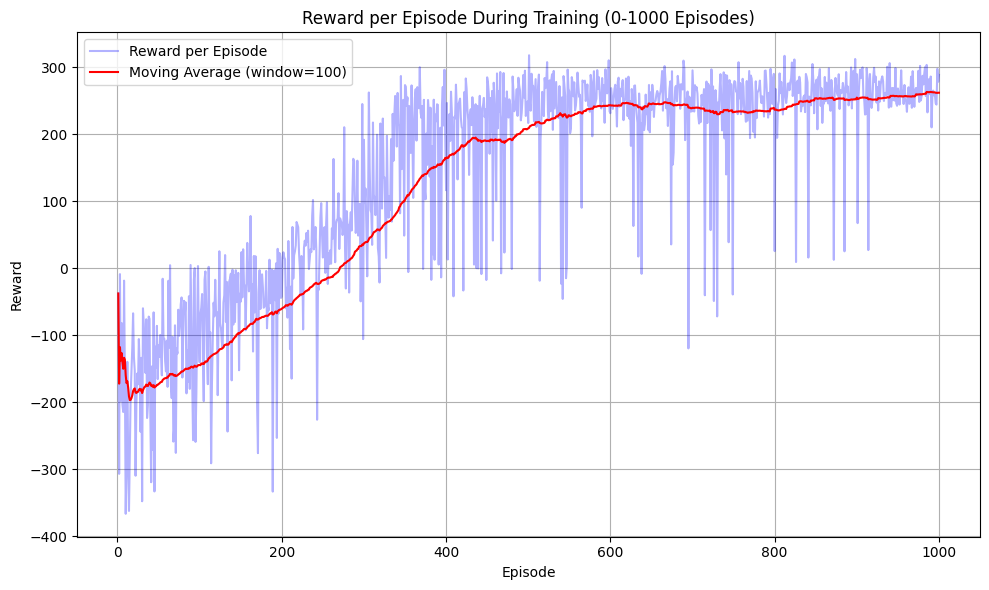

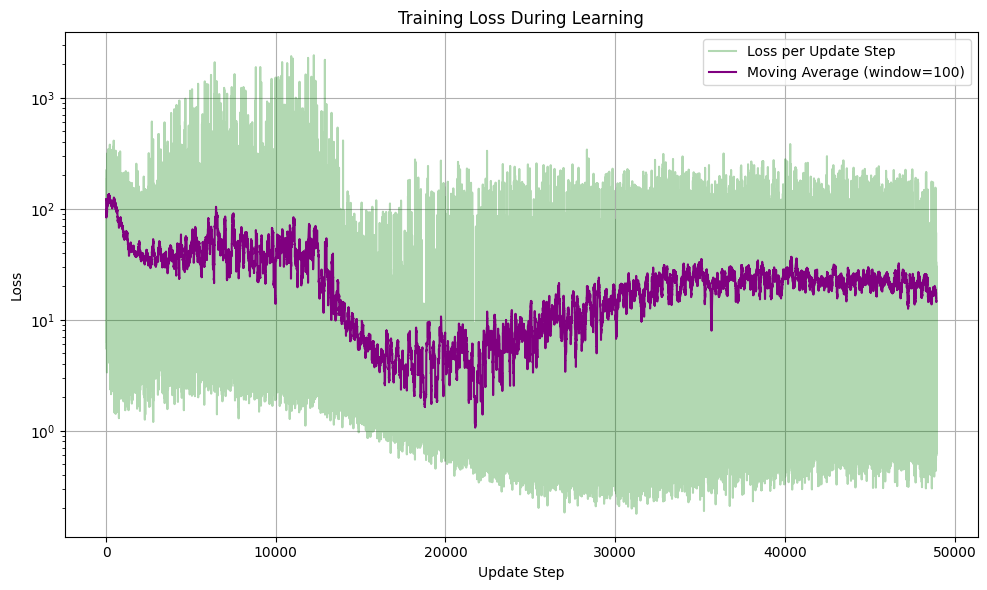

Running Game simulation with Random Action
Random agent total score = -210.75 done in 106 steps


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Random Action video Sim saved
Generating video attempt 1/5...
Attempt 1 complete. Total reward: 238.81
Generating video attempt 2/5...
Attempt 2 complete. Total reward: 248.46
Generating video attempt 3/5...
Attempt 3 complete. Total reward: 268.65
Generating video attempt 4/5...
Attempt 4 complete. Total reward: 260.21
Generating video attempt 5/5...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Attempt 5 complete. Total reward: 294.78
Saving best landing video (reward: 294.78) to lunarlander_TrainedSim.mp4...
Video saved to lunarlander_TrainedSim.mp4


In [10]:
if __name__ == "__main__":

    agent, rewards, losses = train_agent(num_episodes=1000)
    plot_rewards(rewards, save_path='training_rewards_graph.png')
    plot_losses(losses, save_path='training_loss_graph.png')

    run_randomaction_Sim()
    generate_video(agent, video_file="lunarlander_TrainedSim.mp4")